In [2]:
# Config
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('seaborn-white')
%matplotlib inline
from scipy.stats import gamma, poisson
import epyestim
import epyestim.covid19 as covid19
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
sns.set(font_scale=1.5, style="whitegrid")

### Data

In [8]:
print(pd.read_csv('data/COVID19BE.csv', parse_dates=['DATE']).iloc[12:22].to_latex(index=False))

\begin{tabular}{lllllr}
\toprule
      DATE &       PROVINCE &    REGION & AGEGROUP & SEX &  CASES \\
\midrule
2020-03-01 &  VlaamsBrabant &  Flanders &    40-49 &   F &      1 \\
2020-03-01 &  VlaamsBrabant &  Flanders &    40-49 &   M &      1 \\
2020-03-01 &  VlaamsBrabant &  Flanders &    50-59 &   M &      1 \\
2020-03-01 &  VlaamsBrabant &  Flanders &    60-69 &   M &      1 \\
2020-03-02 &      Antwerpen &  Flanders &    40-49 &   M &      1 \\
2020-03-02 &  BrabantWallon &  Wallonia &    10-19 &   F &      1 \\
2020-03-02 &  BrabantWallon &  Wallonia &    10-19 &   M &      1 \\
2020-03-02 &       Brussels &  Brussels &    10-19 &   F &      1 \\
2020-03-02 &       Brussels &  Brussels &    40-49 &   M &      1 \\
2020-03-02 &       Brussels &  Brussels &    50-59 &   F &      1 \\
\bottomrule
\end{tabular}



In [27]:
def make_df(region, start_date=None, end_date=None, series=True):
    cases = pd.read_csv('data/COVID19BE.csv', parse_dates=['DATE'])
    if start_date is not None:
        mask = (cases['DATE'] > start_date) & (cases['DATE'] <= end_date)
        cases = cases.loc[mask]
    
    if region == 'Belgium':
        cases = cases.groupby('DATE').sum()
    else:
        cases = cases.loc[cases['REGION'] == region].groupby('DATE').sum()
    if series:
        cases = cases.squeeze()
        cases.rename('Cases', inplace=True)
    return cases

In [36]:
def plotting(df, ld=None, save=False):
    fig, ax = plt.subplots(1,1, figsize=(16, 6))
    sns.lineplot(data=df, x=df.index, y=df.loc[:,'Q0.5'], color='red')
    ax.fill_between(df.index, 
                    df['Q0.025'], 
                    df['Q0.975'],
                    color='red',
                     alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('R(t) with 95%-CI')
    ax.set_ylim([0,3])
    ax.axhline(y=1)
    if 1 in ld:
        ax.axvline(x='2020-03-13', linestyle='dashed', color='red', label='Lockdown 1')
        ax.axvline(x='2020-05-18', linestyle='dashed', color='green', label='Reopening 1')
    if 2 in ld:
        ax.axvline(x='2020-10-16', linestyle='dashdot', color='red', label='Lockdown 2')
        ax.axvline(x='2020-12-01', linestyle='dashdot', color='green', label='Reopening 2')
    
    #ax.axvline(x='2020-03-13', linestyle='dashed', color='grey', label='Lockdown 1')
    #ax.axvline(x='2020-10-16', linestyle='dashdot', color='grey', label='Lockdown 2')
    plt.legend(loc='upper right')
    #date_form = DateFormatter("%d-%m")
    date_form = DateFormatter("%m-%Y")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    #ax.set_title('Estimate of time-varying effective reproduction number for {}'.format(region))
    if save:
        plt.savefig('/Users/Lassi/desktop/thesis/latex/latex/figures/{}_ld{}_rt.png'.format(region.lower(), ld), bbox_inches='tight')
    
    plt.show()

## Model

### Defining the input distributions

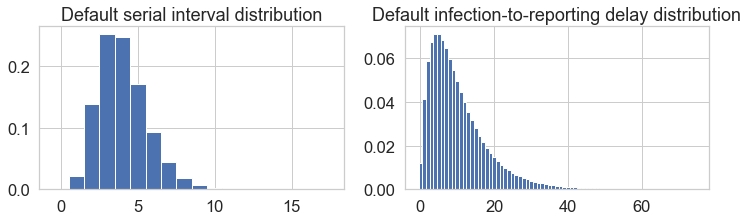

In [20]:
si_distrb = covid19.generate_standard_si_distribution()
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()

#fig = plt.figure(figsize=(10, 5))
#plt.bar(range(len(delay_distrb)), delay_distrb, width=1)
#plt.xlabel("Days")
#plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12,3))

axs[0].bar(range(len(si_distrb)), si_distrb, width=1)
axs[1].bar(range(len(delay_distrb[0:75])), delay_distrb[0:75], width=1)

axs[0].set_title('Default serial interval distribution')
axs[1].set_title('Default infection-to-reporting delay distribution')
#axs[0].set_title('A')
#axs[1].set_title('B')
plt.show()

### Run the model

In [47]:
# Run modeling -> dataframe
def run_model(ld=None, save=False):
    bel_cases = make_df(region, start_date, end_date)
    bel_rt = covid19.r_covid(bel_cases, smoothing_window=window)
    return bel_rt
    #plotting(bel_rt, ld, save)

In [52]:
regions = ['Flanders', 'Wallonia']

all_res = []

for region in regions:
    df = make_df(region)
    res = covid19.r_covid(df, smoothing_window=window)
    all_res.append(res['R_mean'])